# Linear Classification 

In [60]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import layers
from sixand7 import data_utils, layers

np.set_printoptions(precision=2)

## cifar-10 Data Loading and Preprocessing 

In [61]:
from data_utils import load_CIFAR10
cifar10_dir = '/Users/mahrokh/Desktop/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print('x_train: ',X_train.shape)
print('y_train = train label: ',y_train.shape)
print()
print('x_test: ',X_test.shape)
print('y_test = test label: ',y_test.shape)

x_train:  (50000, 32, 32, 3)
y_train = train label:  (50000,)

x_test:  (10000, 32, 32, 3)
y_test = test label:  (10000,)


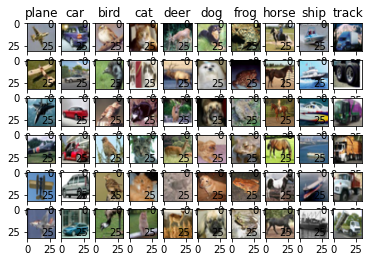

In [62]:
# visualize samples
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'track']
num_class = len(classes)
sample_per_class = 6
# print(list(enumerate(classes)))

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i*num_class + y + 1
        plt.subplot(sample_per_class, num_class, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        if i==0:
            plt.title(cls)
plt.show()

In [65]:
# Spilit data into train, val and test sets, development set(to make faster)
num_training = 49000
num_validation = 1000
num_test = 10000
num_dev = 500

# our validation data
mask = range(num_training, num_training + num_validation)
x_val = X_train[mask]
y_val = y_train[mask]

# our training data
mask = range(num_training)
x_train = X_train[mask]
y_train = y_train[mask]

# our development data
mask = range(np.random.choice(num_training, num_dev,3, replace=False))
x_dev = X_train[mask]
y_dev = y_train[mask]

# our test data
mask = range(num_test)
x_test = X_test[mask]
y_test = y_test[mask]

IndexError: index 49000 is out of bounds for axis 0 with size 49000